In [1]:
import numpy as np
import math
import pandas as pd
import hashlib, random
from sklearn.mixture import GaussianMixture
import copy
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import jsonpickle
from random import shuffle
from collections import defaultdict
import os, json
from datetime import datetime
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
pd.options.display.float_format = '{:,.2f}'.format
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random, json
from tqdm import trange, tqdm
from operator import itemgetter
from analyzer import *
# import query_gen

# sns.set(style='ticks', palette='coolwarm') #this overwrites matplotlib setting so make it run first 
sns.set(style='ticks', palette='Paired') #this overwrites matplotlib setting so make it run first 

# def set_font():
import matplotlib
# http://ishxiao.com/blog/python/2017/07/23/how-to-change-the-font-size-on-a-matplotlib-plot.html

font = {'weight' : 'bold',
#         'size'   : 20,
       'family': 'Linux Libertine O'}
matplotlib.rc('font', **font)

DeepDB stats 
```
2021-09-07 17:25:46,349 [INFO ]  Built SPN in 196.56818502600072 sec
2021-09-07 17:25:46,351 [INFO ]  additional incremental SPN training phase with 69011 samples (1%)
2021-09-07 17:25:46,352 [INFO ]  Incremental adding 69011 datasets to SPN ...
2021-09-07 17:35:51,605 [INFO ]  69011 datasets inserted in 605.2525429849629 secs. (0.00877037780911685 sec./dataset
2021-09-07 17:35:51,606 [INFO ]  Saving ensemble to passdata/taxi/spn_ensembles_0.9/ensemble_single_taxi6_6901012.pkl
```
it is not clear how to use deep db to split the data, the only option "incremental_learning_rate" use the last k% data for inc learning but that's not what their paper is implying. it seems there's anothing sampling process involved but their code does not expose/implemented it yet.

So the data we put in the paper is just the retraining cost, because say if we trained with 80% data and now want to evaluate query after 10% insertion, it is not clear how that can be done.

Accuracy wise, we use a freshly trained deepdb as baseline. Cost wise, we use the above time cost to estimate. i.e. 0.008*7667792*0.1*0.01 = 61s.



In [34]:
#Deepdb 95\% relative error, csv can be find in results/deepdbtaxi, also check deepdb.ipynb
deepdb={1:0.12507444216021404,
2:0.12165419963277156,
3:0.11607646576606476,
4:0.12482357033396557,
5:0.12182195411569281,
6:0.12827237531511396,
7:0.12880593762350562,
8:0.12740804311755044,
9:0.12454713186128373}
#DeepDB training cost, in seconds:
deepdbcost={
1: 69,
2: 76,
3: 80,
4: 86,
5: 90,
6: 107,
7: 108,
8: 105,
9: 103,
}
#DeepDB latency:
deeplatency=[
    0.01030661375419004,
0.009056751508382149,
0.008637920890003443,
0.008324268395372201,
0.006801584658329375,
0.008420225026027765,
0.00876794955355581,
0.007252483597316313,
0.006236395449202973,
]
deeplatency = {i:x*1000 for i, x in enumerate(deeplatency)}

In [35]:
deeplatency

{0: 10.306613754190039,
 1: 9.056751508382149,
 2: 8.637920890003443,
 3: 8.3242683953722,
 4: 6.801584658329375,
 5: 8.420225026027765,
 6: 8.767949553555809,
 7: 7.2524835973163135,
 8: 6.236395449202973}

In [21]:
#Initialization cost of PASS, in ms
# grep ms /home/xiliang/COMPASS/results/end2end128/syncQ/log/*
# partitioning + catching up.
passcost={
1: 555+1505,
2: 454+2860,
3: 513+3709,
4: 500+4243,
5: 528+5411,
6: 452+6371,
7: 473+7429,
8: 433+8054,
9: 552+9127
}
for k, v in passcost.items():
    passcost[k] = v/1000;
print(passcost)

{1: 2.06, 2: 3.314, 3: 4.222, 4: 4.743, 5: 5.939, 6: 6.823, 7: 7.902, 8: 8.487, 9: 9.679}


In [41]:
costs={
    "JanusAQP": passcost,
    "DeepDB": deepdbcost
}

In [30]:
#Sync mode query latency, 2000
#smaller because previously we are using 2x, now 1x.
#ls -v  ../notebooks/results/end2end128/syncQ/log/End2End_* |xargs grep "WallClock" |grep -v "now: -"|awk '{print $(NF-1)}'
qtime = [303,503,811,960,1152,1330,1540,1703,1885]
qlatency = {}
for i in range(1, 10):
    qlatency[i]  = qtime[i-1]/2000
qlatency

{1: 0.1515,
 2: 0.2515,
 3: 0.4055,
 4: 0.48,
 5: 0.576,
 6: 0.665,
 7: 0.77,
 8: 0.8515,
 9: 0.9425}

In [31]:
#Async mode throughput
#raw output can be found ../results/end2end128/IDQ/log/
# ls -v  ../notebooks/results/end2end128/IDQ/log/End2End_* |xargs grep "WallClock"|awk -F' ' '{print $(NF-1)","}'
time=[5486,4264,118,5340,4047,200,4314,4423,203,4449,4601,213,4219,4247,250,4933,4246,310,4585,4327,358,4558,4432,333,4673,4247,504]

icost=[]
dcost=[]
qcost=[]
for i, t in enumerate(time):
    if i % 3 == 0:
        icost.append(t)
    elif i % 3 == 1:
        dcost.append(t)
    else:
        qcost.append(t)

idq = list(zip(icost, dcost, qcost))


In [32]:
id_batch_size = 766000
q_batch_size = 2000
# print("ms/op: Insertion\t Deletion \t Query (This might not matter that much because of async mode)",)
# del is more efficient because insertion requires to remove a sample from reservoir then add the new one. while del is just one operation.
# another reason is for insertion we have to find the nth sample to replace O(k), for deletion this is O(lgk) 
# for i in idq:
#     print(i[0]/id_batch_size, "\t", i[1]/id_batch_size,"\t",  i[2]/q_batch_size)
    
print("op/s    Insertion \tDeletion \tQuery",)
insops = {}
delops = {}
qops={}
asyncops={}
for idx, i in enumerate(idq):
    print((idx+1)/10, "\t", id_batch_size*1000//i[0]," \t",  1000*id_batch_size//i[1], "\t", 1000*q_batch_size//i[2])
    insops[i] = id_batch_size*1000//i[0]
    delops[i] = id_batch_size*1000//i[1]
    qops[i] = q_batch_size*1000//i[2]
asyncops={
    "Insertion": insops,
    "Deletion": delops,
#     "query": qops
}

queryperf = {
    'async': qops,
    'sync': qlatency
}

op/s    Insertion 	Deletion 	Query
0.1 	 139628  	 179643 	 16949
0.2 	 143445  	 189276 	 10000
0.3 	 177561  	 173185 	 9852
0.4 	 172173  	 166485 	 9389
0.5 	 181559  	 180362 	 8000
0.6 	 155280  	 180405 	 6451
0.7 	 167066  	 177027 	 5586
0.8 	 168056  	 172833 	 6006
0.9 	 163920  	 180362 	 3968


In [5]:
#becareful of the file name ordering here, 7667 is for 0.1, should be first one
#routine repartition every 10%
passfiles=[
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-15335-0.1-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-23003-0.1-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-30671-0.1-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-38338-0.1-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-46006-0.1-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-53674-0.1-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-61342-0.1-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-69010-0.1-2000.csv",
]
#random sampling (not reservoir because it is not dynamic)
#under syncQ
randomsfiles=[
"compass.ReservoirSampling_pickup_time_trip_distance-7667-0.01-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-15335-0.01-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-23003-0.01-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-30671-0.01-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-38338-0.01-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-46006-0.01-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-53674-0.01-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-61342-0.01-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-69010-0.01-2000.csv",
]
#continuously handling insertion: reservoir sampling
#under 10tofullpt
rsfiles=[
"compass.ReservoirSampling_pickup_time_trip_distance-7667-0.01-766779-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-15335-0.01-1533558-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-23003-0.01-2300337-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-30671-0.01-3067116-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-38338-0.01-3833895-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-46006-0.01-4600674-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-53674-0.01-5367453-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-61342-0.01-6134232-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-69010-0.01-6901011-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-76677-0.01-7667790-2000.csv"
]
#continuous
cpassfile=[
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-766779-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-1533558-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-2300337-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-3067116-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-3833895-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-4600674-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-5367453-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-6134232-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-6901011-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-7667790-2000.csv",
]
prefix='results/end2end128/syncQ/csv/'
cprefix='results/end2end128/10tofullPT/csv/'
ps = {}
rs = {}
cps = {}
for i in range(1, 10):
    p = 0.1*i
    ps[i] = pd.read_csv(prefix+passfiles[i-1])
    rs[i] = pd.read_csv(cprefix+rsfiles[i-1])
    cps[i] = pd.read_csv(cprefix+cpassfile[i-1])
    if 'qhash' not in rs[i].columns:
        rs[i]['qhash'] = rs[i]['query']
ogt = json.load(open('results/end2end128/syncQ/taxi-percentage.json'))
gt = {}
for k,v in ogt.items():
    gt[int(float(k)*10)] = ogt[k]


In [6]:
rs.keys()


dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
hashq = {}
for i in range(ps[1].shape[0]):
    r = ps[1].iloc[i]
    hashq[r['qhash']] = r['query']

In [8]:
def get_percentile_re(hashq, baseline, gtp, qtype, percentile):
    qtypeid={'cnt':1, 'sum':0, 'avg': 2}
    re = []
    for i in range(baseline.shape[0]):
        r = baseline.iloc[i]
        q = hashq[r['qhash']]
        gtv = gtp[q][qtypeid[qtype]]
        re.append(abs(r[qtype] - gtv)/gtv)
    return np.percentile(re, percentile)

def getre(p, g, ps=[25, 50, 95], qtype="sum"):
    hashq = {}
    for i in range(p.shape[0]):
        r = p.iloc[i]
        hashq[r['qhash']] = r['query']
    for per in ps:
        print("P", per, "PASS:", get_percentile_re(hashq, p, g, qtype, per))

In [10]:
percentile=95
qtype='sum'
passre = {}
rsre = {}
cpassre = {}
for k in range(1, 10):
    p = ps[k]
    r = rs[k]
    cp = cps[k]
    g = gt[k]
    pest = p[['qhash', qtype]]
#     rsre.append(get_percentile_re(hashq, r, g, qtype, percentile))
    passre[k] = get_percentile_re(hashq, p, g, qtype, percentile)
    rsre[k] = get_percentile_re(hashq, r, g, qtype, percentile)
    cpassre[k] = get_percentile_re(hashq, cp, g, qtype, percentile)
#     passre.append(get_percentile_re(hashq, p, g, qtype, percentile))
    print(k, "P", percentile, "RS:", get_percentile_re(hashq, r, g, qtype, percentile))
    print(k, "P", percentile, "R-DPASS:", get_percentile_re(hashq, p, g, qtype, percentile))
    print(k, "P", percentile, "DPASS:", get_percentile_re(hashq, cp, g, qtype, percentile))
#     for 
# print(passre, "\n", rsre)
# baseperf={
#     "R-DPASS": passre,
#     "DPASS": cpassre,
#     "ReservoirSampling": rsre,
#     "DeepDB": deepdb
# }


1 P 95 RS: 0.11449054941098293
1 P 95 R-DPASS: 0.06626002369663966
1 P 95 DPASS: 0.072205839996673
2 P 95 RS: 0.11541893345385404
2 P 95 R-DPASS: 0.04648254960678719
2 P 95 DPASS: 0.04957807827763245
3 P 95 RS: 0.11238128369205909
3 P 95 R-DPASS: 0.03541292811538925
3 P 95 DPASS: 0.050178397202456204
4 P 95 RS: 0.09743533285790398
4 P 95 R-DPASS: 0.030858617432025975
4 P 95 DPASS: 0.05358009745828502
5 P 95 RS: 0.07124651225632836
5 P 95 R-DPASS: 0.021344436039956075
5 P 95 DPASS: 0.05256430580673876
6 P 95 RS: 0.0523044651911808
6 P 95 R-DPASS: 0.026055551826856906
6 P 95 DPASS: 0.05199073387883163
7 P 95 RS: 0.04554007871841685
7 P 95 R-DPASS: 0.02113195966238619
7 P 95 DPASS: 0.05320262411765775
8 P 95 RS: 0.050785563042374304
8 P 95 R-DPASS: 0.021492061912127033
8 P 95 DPASS: 0.052698911659887604
9 P 95 RS: 0.049454703039620566
9 P 95 R-DPASS: 0.022440255846857316
9 P 95 DPASS: 0.051689009646603265
{1: 0.06626002369663966, 2: 0.04648254960678719, 3: 0.03541292811538925, 4: 0.030858

In [52]:

baseperf={
    "JanusAQP": passre,
#     "DPT": cpassre,
    "RS": rsre,
    "DeepDB": deepdb
}

In [49]:
def linesubplot(ax, results, ticks, xlabel, ylabel):
    patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
    markers = ['o', '^', '*', 'v', 'd', 'X', 'P', 'p', '4']
    linestyles= [':', '-.', '--', '-']

    font_size = 25
    xfont = {'weight' : 'bold',
            'size'   : font_size}
    width = 0.6
    our_color = "#3498db"
    baseline_color = "#95a5a6"

    baseline_perf = results
    results = list(baseline_perf.values())[0]
    x_labels = [x*2 for x in results.keys()]

    line_count = -1
    style = defaultdict(dict)

    idx = 0
    for legend, perf in baseline_perf.items():
        perf = list(perf.values())
        color = our_color if ( 'AQP' in legend) else baseline_color
        ax.plot(perf, label=legend, marker=markers[idx],  c = color, mfc = 'black', lw = 3, ms = 15)
        idx += 1

    ax.set_xticks(np.arange(len(ticks)))
    ax.set_xticklabels(ticks, fontsize=font_size-5)

    ax.legend(fontsize=20)

    ax.set_ylabel(ylabel, fontdict = xfont)
    ax.set_xlabel(xlabel, fontdict = xfont)
    ax.yaxis.set_tick_params(labelsize=font_size)

def kbarsubplot(ax, results, ticks, xlabel, ylabel, yrange=None):
    x = np.arange(len(ticks))  # the label locations
    patterns = [ "/" , "\\" , "x" , "*", "o", "O", "." ]
    font_size = 25
    xfont = {'weight' : 'bold',
            'size'   : font_size}
    our_color = "#3498db"
    baseline_color = "#95a5a6"
    
    width = 0.25  # the width of the bars
    labels = range(1, len(ticks)+1)

    k = 0
    for leg, d in results.items():
        bar = list(d.values())
        print(bar)
        rects = ax.bar(x - width/2 + k*width, bar, width, label=leg, hatch=patterns[k])#, color=baseline_color)
        k+= 1
#         rects2 = ax.bar(x + width/2, bar2, width, label=leg2, hatch=patterns[1])#, color=our_color)

    ax.set_xticks(np.arange(len(ticks)))
    ax.set_xticklabels(ticks, fontsize=font_size-5)
#     ax.set_yscale('log')
    if yrange:
        ax.set_ylim(*yrange)
    ax.legend(fontsize=20)

    ax.set_ylabel(ylabel, fontdict = xfont)
    ax.set_xlabel(xlabel, fontdict = xfont)
    ax.yaxis.set_tick_params(labelsize=font_size)
    
    
def plot2(leftargs, leftfunc, rightargs, rightfunc, title = None, fname = None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    font_size = 25
    xfont = {'weight' : 'bold',
            'size'   : font_size}
    our_color = "#3498db"
    baseline_color = "#95a5a6"

    leftargs['ax'] = axs[0]
    leftfunc(**leftargs)
    
    rightargs['ax'] = axs[1]
    rightfunc(**rightargs)

    fig.tight_layout()
    plt.show()
    if fname:
        fig.savefig("figures/"+fname+".pdf", bbox_inches='tight')

In [40]:
baseperf

{'JanusAQP': {1: 0.06626002369663966,
  2: 0.04648254960678719,
  3: 0.03541292811538925,
  4: 0.030858617432025975,
  5: 0.021344436039956075,
  6: 0.026055551826856906,
  7: 0.02113195966238619,
  8: 0.021492061912127033,
  9: 0.022440255846857316},
 'DPT': {1: 0.072205839996673,
  2: 0.04957807827763245,
  3: 0.050178397202456204,
  4: 0.05358009745828502,
  5: 0.05256430580673876,
  6: 0.05199073387883163,
  7: 0.05320262411765775,
  8: 0.052698911659887604,
  9: 0.051689009646603265},
 'ReservoirSampling': {1: 0.11449054941098293,
  2: 0.11541893345385404,
  3: 0.11238128369205909,
  4: 0.09743533285790398,
  5: 0.07124651225632836,
  6: 0.0523044651911808,
  7: 0.04554007871841685,
  8: 0.050785563042374304,
  9: 0.049454703039620566},
 'DeepDB': {1: 0.12507444216021404,
  2: 0.12165419963277156,
  3: 0.11607646576606476,
  4: 0.12482357033396557,
  5: 0.12182195411569281,
  6: 0.12827237531511396,
  7: 0.12880593762350562,
  8: 0.12740804311755044,
  9: 0.12454713186128373}}

In [44]:
asyncops

{'insertion': {(5486, 4264, 118): 139628,
  (5340, 4047, 200): 143445,
  (4827, 4808, 257): 158690,
  (4449, 4601, 213): 172173,
  (4219, 4247, 250): 181559,
  (4933, 4246, 310): 155280,
  (4585, 4327, 358): 167066,
  (4558, 4432, 333): 168056,
  (4673, 4247, 504): 163920},
 'deletion': {(5486, 4264, 118): 179643,
  (5340, 4047, 200): 189276,
  (4827, 4808, 257): 159317,
  (4449, 4601, 213): 166485,
  (4219, 4247, 250): 180362,
  (4933, 4246, 310): 180405,
  (4585, 4327, 358): 177027,
  (4558, 4432, 333): 172833,
  (4673, 4247, 504): 180362}}

[2.06, 3.314, 4.222, 4.743, 5.939, 6.823, 7.902, 8.487, 9.679]
[69, 76, 80, 86, 90, 107, 108, 105, 103]


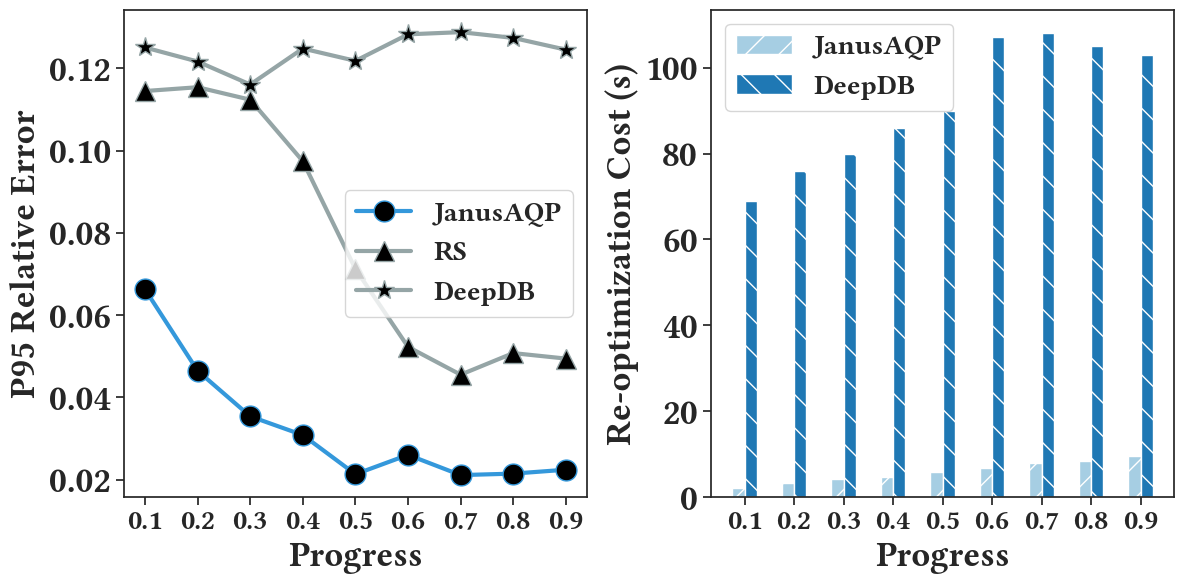

'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [53]:

largs = dict(results=baseperf,
             ticks=[x/10 for x in range(1, 10)], 
             xlabel="Progress", 
             ylabel="P95 Relative Error"
            )

rargs = dict(results=costs,
             ticks=[x/10 for x in range(1, 10)], 
             xlabel="Progress", 
             ylabel="Re-optimization Cost (s)")

plot2(largs, linesubplot, rargs, kbarsubplot, fname="end2end-taxi-2k-p95re-cost-128")

[139628, 143445, 177561, 172173, 181559, 155280, 167066, 168056, 163920]
[179643, 189276, 173185, 166485, 180362, 180405, 177027, 172833, 180362]


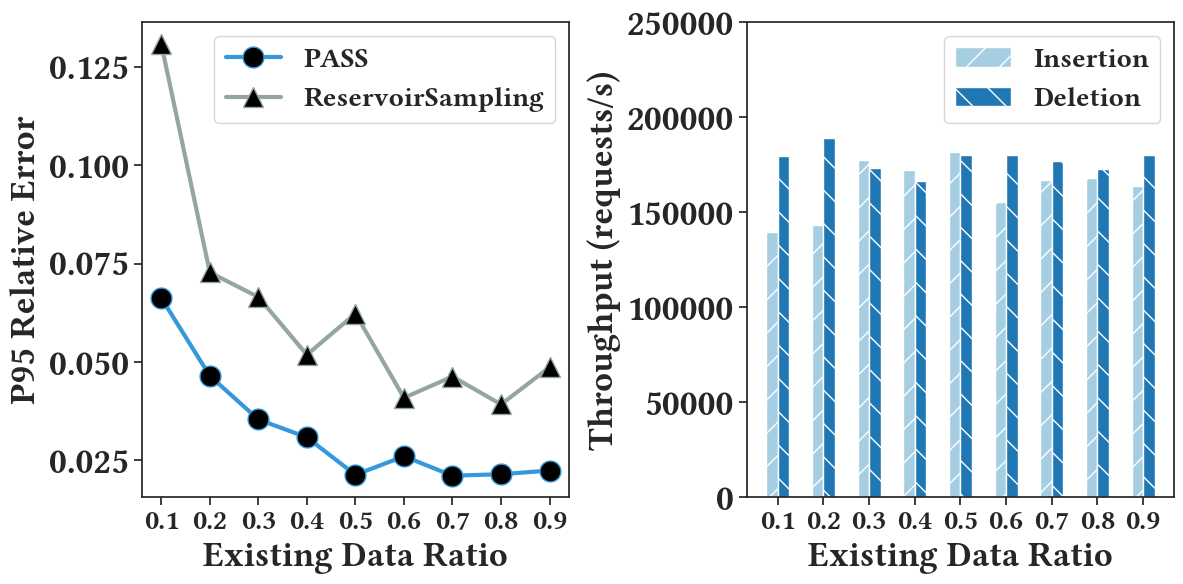

'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [64]:

largs = dict(results=baseperf,
             ticks=[x/10 for x in range(1, 10)], 
             xlabel="Existing Data Ratio", 
             ylabel="P95 Relative Error"
            )

rargs = dict(results=asyncops,
             ticks=[x/10 for x in range(1, 10)], 
             yrange = (0, 250000),
             xlabel="Existing Data Ratio", 
             ylabel="Throughput (requests/s)")

plot2(largs, linesubplot, rargs, kbarsubplot, fname="end2end-taxi-2k-p95re-insdel-128")

[139628, 143445, 177561, 172173, 181559, 155280, 167066, 168056, 163920]
[179643, 189276, 173185, 166485, 180362, 180405, 177027, 172833, 180362]
[0.1515, 0.2515, 0.4055, 0.48, 0.576, 0.665, 0.77, 0.8515, 0.9425]
[10.306613754190039, 9.056751508382149, 8.637920890003443, 8.3242683953722, 6.801584658329375, 8.420225026027765, 8.767949553555809, 7.2524835973163135, 6.236395449202973]


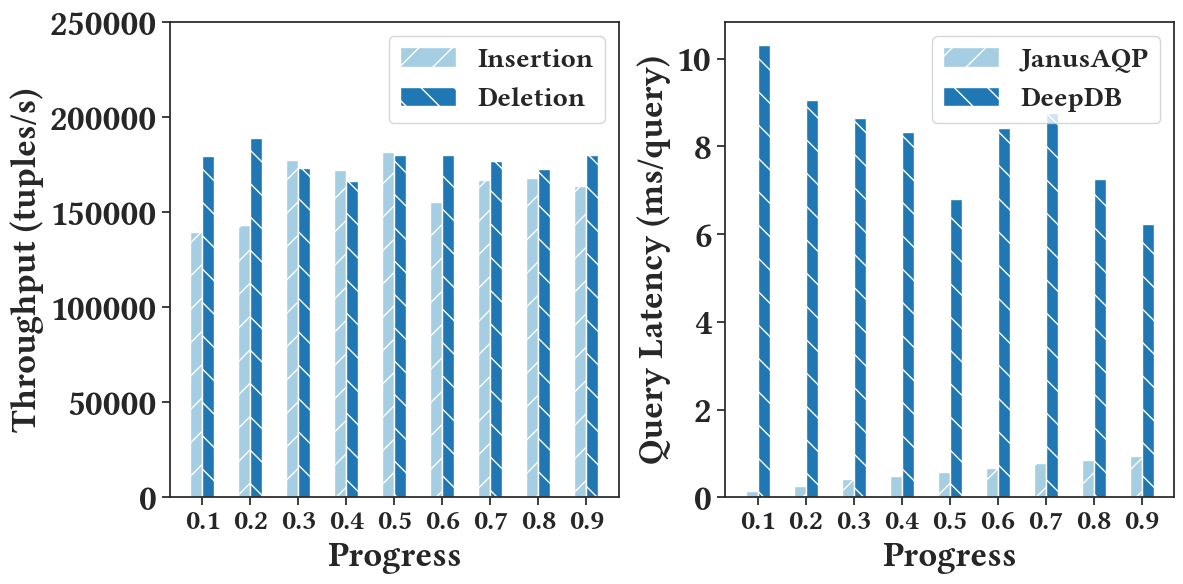

'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [51]:

largs = dict(results=asyncops,
             ticks=[x/10 for x in range(1, 10)], 
             yrange = (0, 250000),
             xlabel="Progress", 
             ylabel="Throughput (tuples/s)")

rargs = dict(results={'JanusAQP': qlatency, 'DeepDB': deeplatency},
             ticks=[x/10 for x in range(1, 10)], 
             xlabel="Progress", 
             ylabel="Query Latency (ms/query)")

plot2(largs, kbarsubplot, rargs, kbarsubplot, fname="end2end-taxi-2k-throughput-128")

[16949, 10000, 9852, 9389, 8000, 6451, 5586, 6006, 3968]
[0.1515, 0.2515, 0.4055, 0.48, 0.576, 0.665, 0.77, 0.8515, 0.9425]


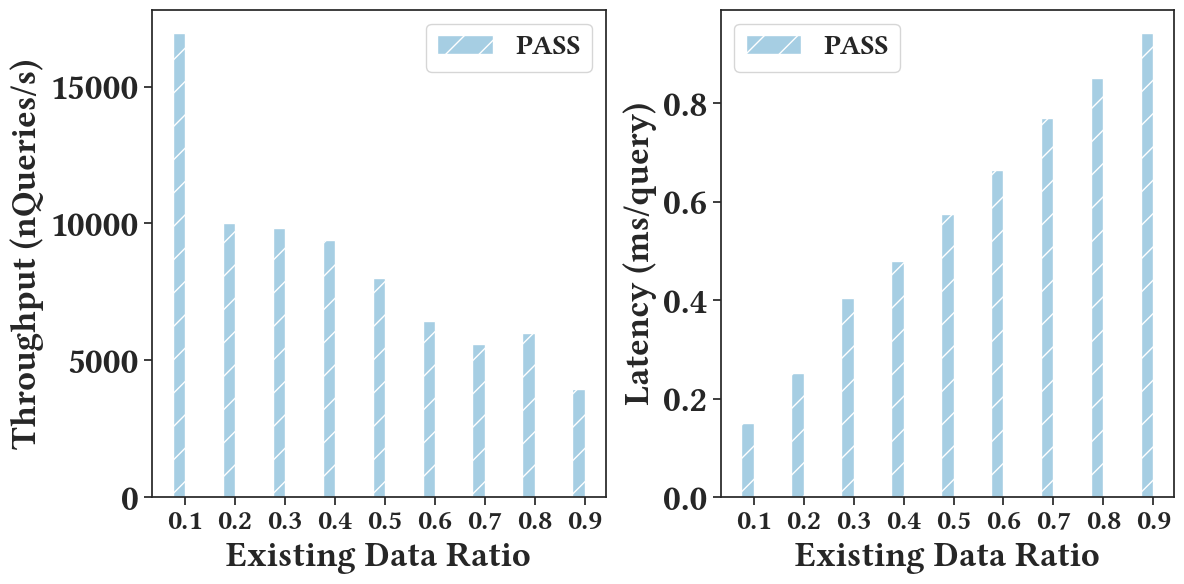

'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [66]:

largs = dict(results={'PASS': queryperf['async']},
             ticks=[x/10 for x in range(1, 10)], 
             xlabel="Existing Data Ratio", 
             ylabel="Throughput (nQueries/s)"
            )

rargs = dict(results={'PASS': queryperf['sync']},
             ticks=[x/10 for x in range(1, 10)], 
             xlabel="Existing Data Ratio", 
             ylabel="Latency (ms/query)")

plot2(largs, kbarsubplot, rargs, kbarsubplot, fname="end2end-taxi-2k-p95re-query-128")